In [ ]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt

# **XGBoost**

In [2]:
import pandas as pd
data= pd.read_csv('processedData.csv')

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data['Time'] = pd.to_datetime(data['Time']) # Convert Time to datetime format
data['Time'] = data['Time'].astype(int) / 10**9 # Convert Time to UNIX timestamp format
data['Direction'] = pd.to_numeric(data['Direction'], errors='coerce') # Convert Direction to numeric format
# preprocess the data as necessary

# Split the data into training and testing sets
X = data.drop(['ActivePower'], axis=1)
y = data['ActivePower']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)

# Train your XGBoost model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate your XGBoost model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print("RMSE: %.2f" % rmse)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE: 15.51


# **LSTM**

In [ ]:
df= pd.read_csv('processedData.csv')
df = df.set_index('Time')

In [45]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 5
neurons_exp = 10
predict_values_exp = 1000
lag_exp=24

In [46]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model
    print(model.summary)
    
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]


In [47]:

'''Drop all the features as we will not be having any in production'''

df.drop(['ActivePower', 'WindSpeed', 'WindDirection', 'Loss', 'month', 'Day', 'Hours', 'Minutes', 'mean_Direction', 'Direction'], axis=1, inplace=True)

df.head()

,Theoretical_Power_Curve
Time,
01 01 2018 00:00,416.33
01 01 2018 00:10,519.92
01 01 2018 00:20,390.90
01 01 2018 00:30,516.13
01 01 2018 00:40,491.70


In [49]:
for i in range(0,10):
  df = df[:-1]
df.tail()

# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [50]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

15055/15055 [==============================] - 34s 2ms/step - loss: 0.0061


In [51]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 448ms/step
Hour=1, Predicted=325.336264, Expected=1062.060000
1/1 [==============================] - 0s 36ms/step
Hour=2, Predicted=1019.002180, Expected=1361.280000
1/1 [==============================] - 0s 32ms/step
Hour=3, Predicted=1315.186412, Expected=1552.650000
1/1 [==============================] - 0s 22ms/step
Hour=4, Predicted=1505.590542, Expected=1132.490000
1/1 [==============================] - 0s 27ms/step
Hour=5, Predicted=1086.650676, Expected=673.600000
1/1 [==============================] - 0s 30ms/step
Hour=6, Predicted=619.850087, Expected=321.010000
1/1 [==============================] - 0s 25ms/step
Hour=7, Predicted=268.414604, Expected=53.200000
1/1 [==============================] - 0s 23ms/step
Hour=8, Predicted=-3.884784, Expected=47.590000
1/1 [==============================] - 0s 24ms/step
Hour=9, Predicted=-0.800464, Expected=80.630000
1/1 [==============================] - 0s 24ms/step
Hour=10, Predicted=22.9352

In [52]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 10)                   1400      
                                                                 
 dense_1 (Dense)             (1, 1)                    11        
                                                                 
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


## **Calculating Mean Absolute Error**

In [53]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))

Mean Absolute Percent Error:  0.4354869553324992


# **Final Prediction Plot**

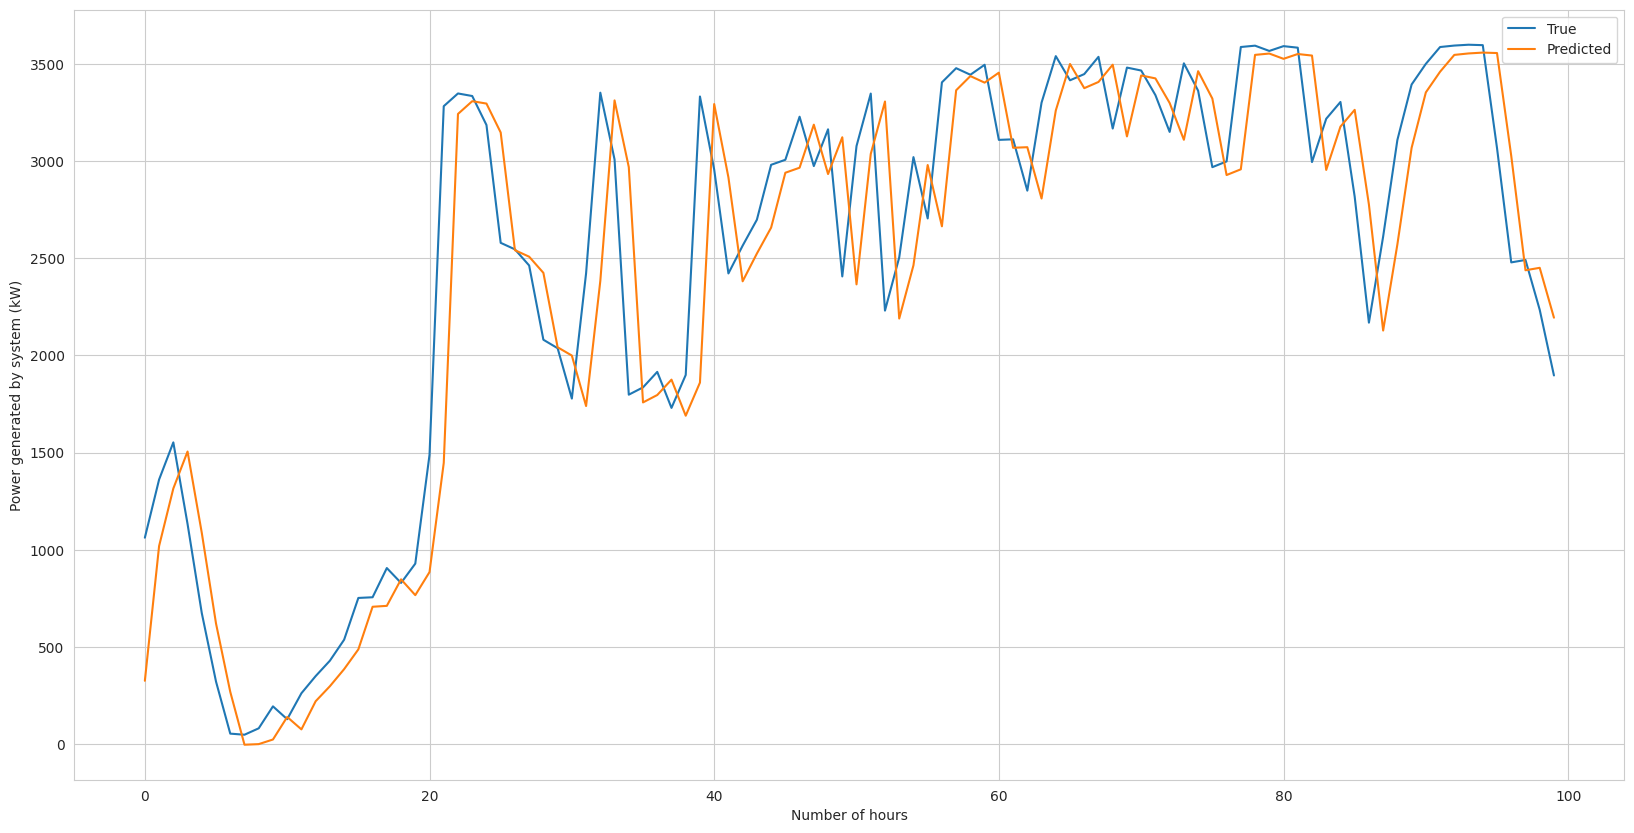

In [56]:
# line plot of observed vs predicted
import seaborn as sns
from matplotlib import pyplot
sns.set_style("whitegrid")
pyplot.figure(figsize=(20,10))
pyplot.plot(expectations_plot[0:100], label="True")
pyplot.plot(predictions_plot[0:100], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()